# Exploratory data analysis

In [2]:
# Loading the data
import pickle
import numpy as np

local_filename = '../dataset/data.pkl'
dataset = []

with open(local_filename, "rb") as file:
    # Deserializing which is a transforming serialized data back into its original format
    dataset = pickle.load(file)

trainDataset = dataset["trainDataset"]
testDataset = dataset["testDataset"]

print("Train Size: {} Test Size: {}".format(len(trainDataset), len(testDataset)))

Train Size: 60000 Test Size: 27561


In [3]:
import numpy as np

X_train = np.array([td["image"] for td in trainDataset])
y_train = np.array([td["label"] for td in trainDataset])
X_test = np.array([td["image"] for td in testDataset])
y_test = np.array([td["label"] for td in testDataset])

## Visualizing Dataset

In [4]:
import matplotlib.pyplot as plt

In [5]:
def show_images(x, y, title_str='Label'):
    for c in range(1, 10):
        plt.subplot(3, 3, c)
        i = np.random.randint(len(x)) # Generate random integer number
        im = x[i] # get i-th image
        plt.axis("off")
        label = y[i] # get i-th label
        plt.title("{} = {}".format(title_str, label))
        plt.imshow(im, cmap='Greys')

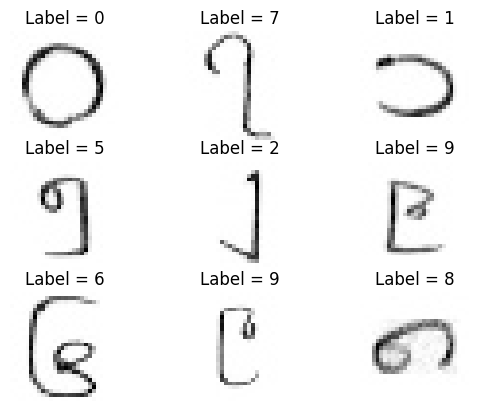

In [6]:
# Visualzing training set
show_images(X_train, y_train, title_str='Label')

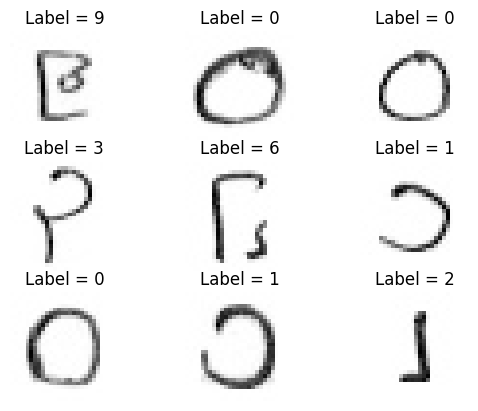

In [7]:
# Visualzing test set
show_images(X_test, y_test, title_str='Label')

## Data Preprocessing

In [8]:
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (27561, 28, 28)
y_test shape: (27561,)


In [9]:
# Labels
label = np.unique(y_train)
num_classes = len(label)
print("Number of classes:", num_classes)
print("Unique Labels:", label)

Number of classes: 10
Unique Labels: [0 1 2 3 4 5 6 7 8 9]


In [10]:
# Reshape images
X_train = X_train.astype(np.float32).reshape(len(X_train), 28, 28, 1)
y_train = y_train.reshape(len(y_train), 1)
X_test = X_test.astype(np.float32).reshape(len(X_test), 28, 28, 1)
y_test = y_test.reshape(len(y_test), 1)

In [11]:
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 1)
X_test shape: (27561, 28, 28, 1)
y_test shape: (27561, 1)


In [12]:
# Split into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Note:** I created a custom preprocessing layer which can encapsulate our preprocessing logic and become part of the model. When we save the model, these custom preprocessing layers will be included.

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Custom preprocessing layer with Normalization
class CustomPreprocessNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomPreprocessNormalizationLayer, self).__init__()

    def call(self, inputs):
        # Normalize pixel values to [0, 1]
        normalized_images = inputs / 255.0

        return normalized_images

In [14]:
# Custom preprocessing layer with Standardization
class CustomPreprocessStandardizationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomPreprocessStandardizationLayer, self).__init__()

    def call(self, inputs):
        # Standardize pixel values into mean=0 and std=1
        standardized_images = (inputs - tf.math.reduce_mean(inputs)) / tf.math.reduce_std(inputs)

        return standardized_images

# Building the model

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [16]:
def create_model():
    # Create a Sequential model
    model = Sequential()

    # Add the CustomPreprocessNormalizationLayer as the first layer
    model.add(CustomPreprocessNormalizationLayer())

    ### Add Convolutional and MaxPooling layers

    # CONV => RELU => MAX-POOLING
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))

    # CONV => RELU => MAX-POOLING => CONV
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    # Flatten the output for Dense layers
    model.add(Flatten())

    # Add Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer with a dropout rate of 0.5

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [17]:
def create_deeper_model():
    model = Sequential()

    # Add the CustomPreprocessNormalizationLayer as the first layer
    model.add(CustomPreprocessNormalizationLayer())

    # Convolutional layer block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Convolutional layer block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Convolutional layer block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Flatten the output for Dense layers
    model.add(Flatten())

    # Dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [18]:
model = create_deeper_model()
model.build(input_shape=(None, 28, 28, 1))
model.summary() # Print the model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_preprocess_normaliza  (None, 28, 28, 1)        0         
 tion_layer (CustomPreproces                                     
 sNormalizationLayer)                                            
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                        

In [19]:
# Configures the model for training
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# use TensorBoard, princess Aurora!
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [21]:
# Train the model
epoch = 10
history = model.fit(X_train, y_train,
                    epochs=epoch,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/10
375/375 [==============================] - 22s 11ms/step - loss: 0.4610 - accuracy: 0.8391 - val_loss: 0.0363 - val_accuracy: 0.9892
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0616 - accuracy: 0.9835 - val_loss: 0.0192 - val_accuracy: 0.9952
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0395 - accuracy: 0.9898 - val_loss: 0.0189 - val_accuracy: 0.9958
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0327 - accuracy: 0.9920 - val_loss: 0.0196 - val_accuracy: 0.9962
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0287 - accuracy: 0.9931 - val_loss: 0.0163 - val_accuracy: 0.9958
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0257 - accuracy: 0.9940 - val_loss: 0.0165 - val_accuracy: 0.9963
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0243 - accuracy: 0.9941 - val_loss: 0.0163 - val_accuracy: 0.996

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

862/862 [==============================] - 3s 3ms/step - loss: 0.0129 - accuracy: 0.9972
Test accuracy: 99.72%


In [24]:
predictions = model.predict(X_test) # Make predictions towards the test set

862/862 [==============================] - 2s 2ms/step


In [25]:
np.argmax(predictions[1]), y_test[1] # If two are the same, got it right

(5, array([5], dtype=uint8))

In [26]:
y_test_pred = np.argmax(predictions, axis=1)

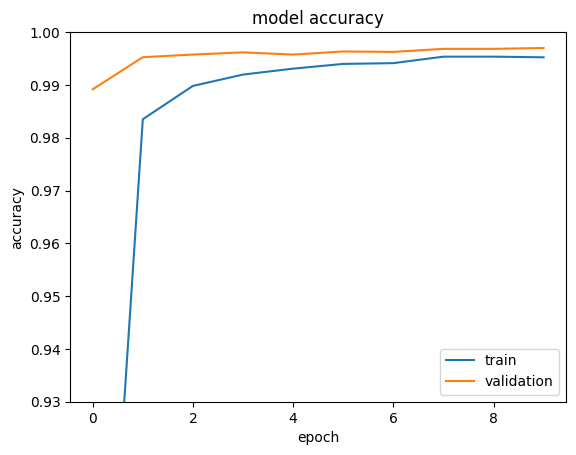

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylim([0.93, 1.0])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train','validation'],loc='lower right')
plt.show()

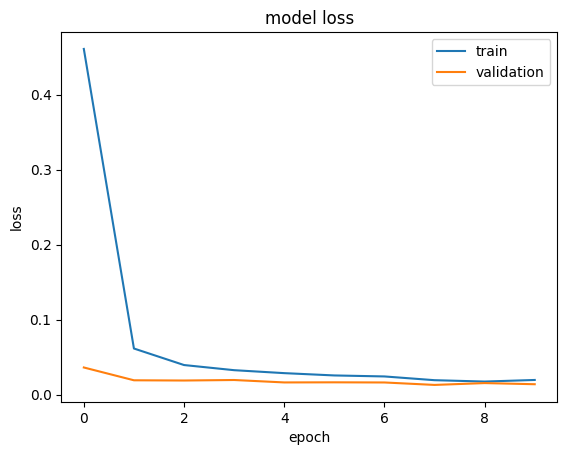

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train','validation'],loc='upper right')
plt.show()

# Model Evaluation

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [30]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_test_pred, average = 'macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_test_pred, average = 'macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_test_pred, average = 'macro')
print('F1 score: %f' % f1)

Accuracy: 0.997170
Precision: 0.995383
Recall: 0.997577
F1 score: 0.996474


# Testing a real-world image

In [31]:
image_path = "../images/Burmese_number_5.jpg"
img_input = tf.io.read_file(image_path)
img_input = tf.image.decode_image(img_input)
img_input = tf.image.rgb_to_grayscale(img_input)
img_input = 255 - img_input
img_input = tf.image.resize(img_input, size=(28, 28), method='bilinear')

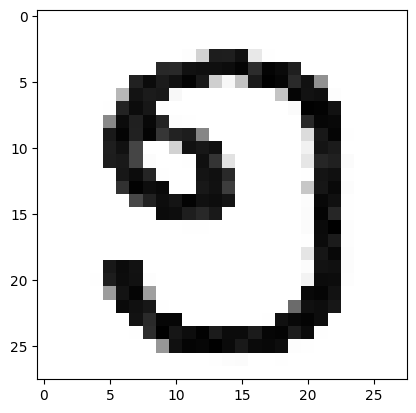

In [32]:
plt.imshow(img_input, cmap='Greys')

In [33]:
img_input = tf.expand_dims(img_input, axis=0)

In [34]:
y_input_pred = model.predict(img_input)
print(np.argmax(y_input_pred))

1/1 [==============================] - 0s 218ms/step
5


# Save Model

In [35]:
# save the model using "SavedModel" format
model.save('../model')

In [36]:
# save the model using "HDF5" format
model.save('../model.h5')

In [38]:
loaded_model = tf.keras.models.load_model("../model")

# Use the loaded model for predictions
predictions = loaded_model.predict(img_input)

1/1 [==============================] - 0s 131ms/step


In [39]:
print(np.argmax(predictions))

5
